In [47]:
import pandas as pd
from tqdm import tqdm
from pymongo import MongoClient
import py_vncorenlp
import re
from collections import Counter
import os
from collections import defaultdict
import numpy as np
from math import log
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
import math
import re
import unicodedata
from dotenv import load_dotenv

load_dotenv()

MONGO_URI = os.getenv("MONGO_URI")
client = MongoClient(MONGO_URI)
db = client["nlp"]

article_collection = db["article"]      

In [2]:
tf_idf_collection = db["article_tf_idf"]
list_tf_idf = list(tf_idf_collection.find({}))


rows = []
for doc in list_tf_idf:
    article_id = doc['articleId']
    tf_idf = doc.get('tf_idf', {})
    tf_idf['articleId'] = article_id
    rows.append(tf_idf)

df_tf_idf_full = pd.DataFrame(rows)

df_tf_idf_full.set_index('articleId', inplace=True)
df_tf_idf_full = df_tf_idf_full.fillna(0)

In [49]:
article_collection = db["article"]
list_articles = list(article_collection.find({}))

df_articles = pd.DataFrame(list_articles)

def fix_spacing(text):
    text = re.sub(r'([.,!?;:])(?=\S)', r'\1 ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def is_writer_signature(sentence):
    sentence = sentence.strip().rstrip('.')
    
    if len(sentence.split()) <= 3 and sentence == sentence.title():
        return True
    
    if re.fullmatch(r'[A-Z]\.?', sentence) or re.fullmatch(r'[A-Z][a-z]+(\s[A-Z][a-z]+)?', sentence):
        return True

    if "Thực hiện" in sentence or sentence.upper() == sentence:
        return True

    return False

def remove_writer_name(text):
    sentences = [s.strip() for s in text.strip().split('.') if s.strip()]
    if not sentences:
        return text
    last = sentences[-1]
    if is_writer_signature(last):
        return '. '.join(sentences[:-1]) + '.' if len(sentences) > 1 else ''
    return text

# clear stuff like \n \xa0... from df['content]
df_articles['content'] = df_articles['content'].apply(lambda x: re.sub(r'[\n\r\t\xa0\u200b\u202f]+', ' ', str(x)).strip())
# fix spacing
df_articles['content'] = df_articles['content'].apply(fix_spacing)
# remove writer name
df_articles['content'] = df_articles['content'].apply(remove_writer_name)

In [37]:
def expand_query(token, model, topn=5):
    expanded_tokens = {token}  

    if token in model.wv:
        similar_words = model.wv.most_similar(token, topn=topn)
        for word, _ in similar_words:
            expanded_tokens.add(word.replace('_', ' ')) 

    return expanded_tokens


In [5]:
def rank_documents_by_query(query, tf_idf, word_model, tokenizer, stopwords, expansion_weight=0.25):
    # Tokenize query
    segmented = tokenizer.word_segment(query)
    query_tokens = []
    for sentence in segmented:
        words = sentence.split()
        words = [w.replace("_", " ") for w in words]
        words = [w.lower() for w in words if w.lower() not in stopwords]
        query_tokens.extend(words)

    word_counts = {}

    for token in query_tokens:
        word_counts[token] = word_counts.get(token, 0) + 1 
        expanded_tokens = expand_query(token, word_model, topn=5)
        for expanded in expanded_tokens:
            if expanded != token and expanded not in stopwords:
                word_counts[expanded] = word_counts.get(expanded, 0) + expansion_weight 

    total_terms = sum(word_counts.values())
    if total_terms == 0:
        return []

    word_list = tf_idf.columns
    query_vector = np.zeros(len(word_list))

    for i, term in enumerate(word_list):
        if term in word_counts:
            query_vector[i] = word_counts[term] / total_terms

    cosin_sim = cosine_similarity([query_vector], tf_idf.values)[0]

    article_ids = tf_idf.index.tolist()
    ranked = sorted(zip(article_ids, cosin_sim), key=lambda x: x[1], reverse=True)

    return ranked


In [40]:
def search_articles(query):
    results = rank_documents_by_query(query, df_tf_idf_full, word2vec_model, rdrsegmenter, stopwords)
    result_ids = results[:10]
    result_articles = list(article_collection.find({"id": {"$in": [item[0] for item in result_ids]}}))
    return result_articles

In [3]:
import py_vncorenlp
import os
original_cwd = os.getcwd()
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg", "pos", "ner", "parse"], save_dir=os.path.join(original_cwd, "vncorenlp"))
os.chdir(original_cwd)

In [22]:
with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = set(line.strip().lower() for line in f if line.strip())
stopwords.add('sto')

In [18]:
from gensim.models import Word2Vec


word2vec_model = Word2Vec.load("word2vec_vi_bao_st.model")

In [ ]:
def most_similar_stopword(word, model, topn=10):
    if word in model.wv:
        similar_words = model.wv.most_similar(word, topn=topn)
        return [(w.replace('_', ' '), score) for w, score in similar_words]
    else:
        return []

In [21]:
similar_words = word2vec_model.wv.most_similar("điều kiện", topn=10)
for word, score in similar_words:
    print(f"{word}: {score:.4f}")


thuận lợi: 0.5292
hoạch định: 0.5065
trợ lực: 0.4868
nghẽn: 0.4859
chưa thể: 0.4819
tư liệu sản xuất: 0.4810
không những: 0.4723
cơ hội: 0.4714
quyền năng: 0.4688
đúng mức: 0.4676


In [24]:
annotate = rdrsegmenter.annotate_text('giao thông trên các tuyến đường chính ở thành phố sóc trăng trong giờ cao điểm sáng nay như thế nào')

In [17]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_dependency_tree(tokens):
    # Step 1: Build graph and labels
    G = nx.DiGraph()
    labels = {}

    for token in tokens:
        idx = token["index"]
        word = token["wordForm"]
        head = token["head"]
        dep = token["depLabel"]
        
        G.add_node(idx, label=word)
        labels[idx] = f"{idx}: {word}"
        if head != 0:
            G.add_edge(head, idx, label=dep)

    # Step 2: Find root
    root = next((t["index"] for t in tokens if t["head"] == 0), None)
    if root is None:
        raise ValueError("No root found in the token list.")

    # Step 3: Tree layout (top-down)
    def hierarchy_pos(G, root, width=1.0, vert_gap=0.4, vert_loc=0, xcenter=0.5, pos=None):
        if pos is None:
            pos = {root: (xcenter, vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.successors(root))
        if len(children) != 0:
            dx = width / len(children)
            next_x = xcenter - width / 2 - dx / 2
            for child in children:
                next_x += dx
                pos = hierarchy_pos(G, child, width=dx, vert_gap=vert_gap,
                                    vert_loc=vert_loc - vert_gap, xcenter=next_x, pos=pos)
        return pos

    # Step 4: Draw graph
    pos = hierarchy_pos(G, root)
    plt.figure(figsize=(14, 8))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=2000,
            node_color="lightblue", font_size=10)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    plt.axis('off')
    plt.show()


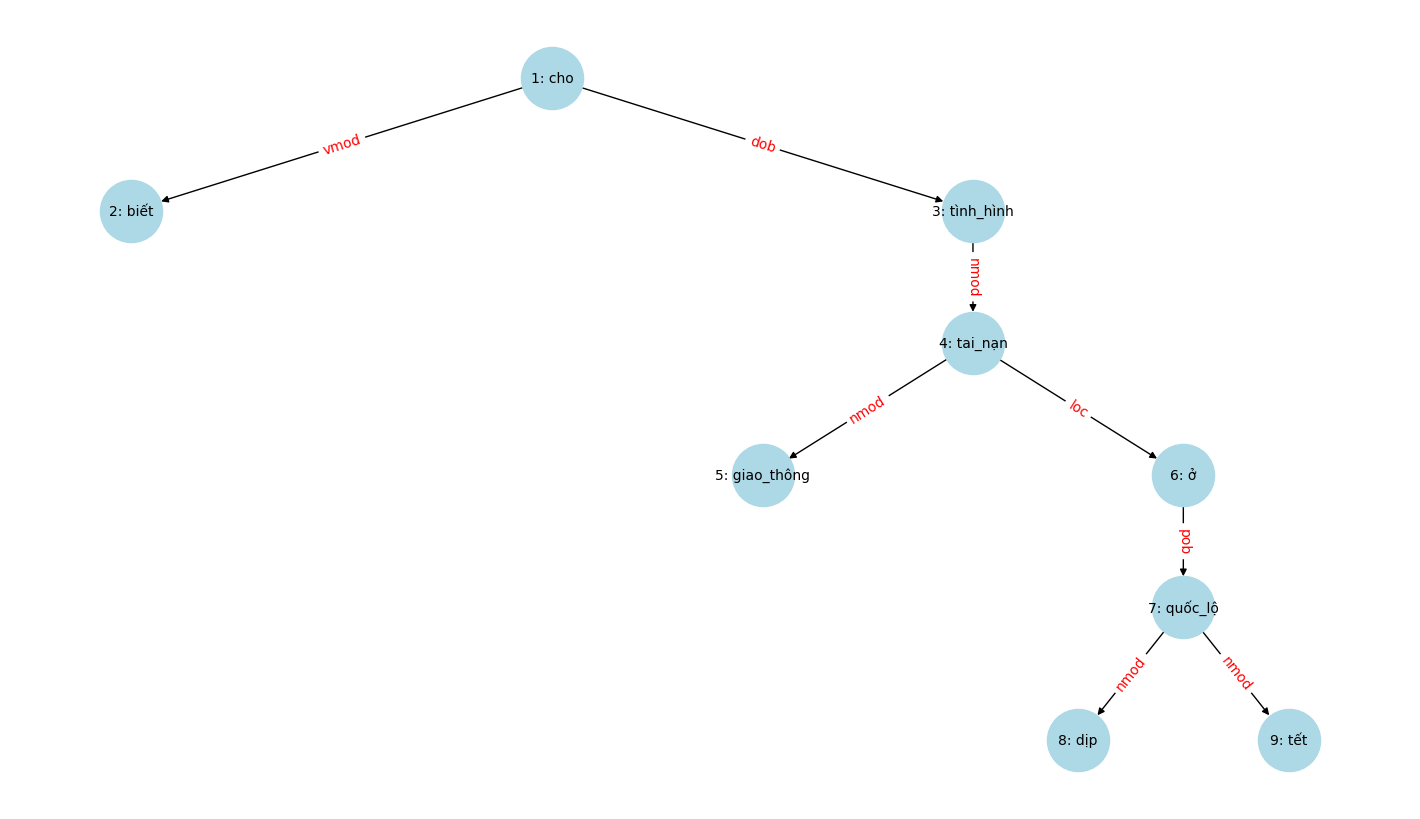

In [18]:
draw_dependency_tree(rdrsegmenter.annotate_text('cho biết tình hình tai nạn giao thông ở quốc lộ dịp tết')[0])

In [60]:
import kenlm

kenlm_model = kenlm.Model("vi_model_6gramVinToken.binary")

In [3]:
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM, BertModel
import torch

model_vin = AutoModel.from_pretrained("vinai/phobert-base", torch_dtype="auto", cache_dir="./transformers_cache")
tokenizer_vin = AutoTokenizer.from_pretrained("vinai/phobert-base", cache_dir="./transformers_cache")

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def encode_sentence(sentence, model, tokenizer):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
    
    with torch.no_grad():
        outputs = model(**inputs)

    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding


def similarity_viBERT(sent1, sent2, model, tokenizer):
    vec1 = encode_sentence(sent1, model, tokenizer).numpy() 
    vec2 = encode_sentence(sent2, model, tokenizer).numpy()
    
    sim = cosine_similarity(vec1, vec2)[0][0]
    return sim


In [11]:
padw = 'tình hình '

s_base = "tai nạn giao thông quốc lộ"
s2 = padw + "tai nạn giao thông quốc lộ"
s3 ="tai nạn giao thông"
s4 = "tai nạn quốc lộ"
s5 = "giao thông quốc lộ"
s6 = "giao thông"

In [70]:
print(similarity_viBERT(s_base, s2, model_fpt, tokenizer_fpt))
print(similarity_viBERT(s_base, s3, model_fpt, tokenizer_fpt))
print(similarity_viBERT(s_base, s4, model_fpt, tokenizer_fpt))
print(similarity_viBERT(s_base, s5, model_fpt, tokenizer_fpt))
print(similarity_viBERT(s_base, s6, model_fpt, tokenizer_fpt))

c:\Python310\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


0.8153698
0.91143876
0.7004467


c:\Python310\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Python310\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Python310\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


0.8698145
0.7216284


c:\Python310\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [ ]:
print(s_base)
print(f'{s2}: {similarity_viBERT(s_base, s2, model_vin, tokenizer_vin)}')
print(f'{s3}: {similarity_viBERT(s_base, s3, model_vin, tokenizer_vin)}')
print(f'{s4}: {similarity_viBERT(s_base, s4, model_vin, tokenizer_vin)}')
print(f'{s5}: {similarity_viBERT(s_base, s5, model_vin, tokenizer_vin)}')
print(f'{s6}: {similarity_viBERT(s_base, s6, model_vin, tokenizer_vin)}')

tai nạn giao thông quốc lộ
tình hình tai nạn giao thông quốc lộ: 0.919621963369446
tai nạn giao thông: 0.9392341786895697


c:\Python310\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Python310\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Python310\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


tai nạn quốc lộ: 0.9306402373491547
giao thông quốc lộ: 0.8958374215557643
giao thông: 0.8394855533831355


c:\Python310\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
c:\Python310\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [31]:
similarity_viBERT(
    'tình_hình tai_nạn giao_thông quốc_lộ'.replace('_', ' '),
     'tai_nạn giao_thông quốc_lộ'.replace('_', ' '),
     model_vin, tokenizer_vin)

c:\Python310\lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


0.84570456

In [49]:
from sentence_transformers import SentenceTransformer, util

# Load the model
mMiniLM_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")


In [50]:
def similarity_mMiniLM(sent1: str, sent2: str) -> float:
    """
    Compute cosine similarity between two Vietnamese sentences
    using the paraphrase-multilingual-MiniLM-L12-v2 model.
    """
    embeddings = mMiniLM_model.encode([sent1, sent2], convert_to_tensor=True)
    similarity = util.cos_sim(embeddings[0], embeddings[1]).item()
    return similarity

In [68]:
# Example sentences (Vietnamese)
padw = 'tình hình'

s_base = padw + "tai nạn giao thông quốc lộ?"
s2 = "tai nạn giao thông quốc lộ?"
s3 = padw + "tai nạn giao thông?"
s4 = padw + "tai nạn quốc lộ?"
s5 = padw + "giao thông quốc lộ?"
s5 = "giao thông"

score = similarity_mMiniLM(s_base, s2)
print(f"Similarity s2: {score:.4f}")

score = similarity_mMiniLM(s_base, s3)
print(f"Similarity s3: {score:.4f}")

score = similarity_mMiniLM(s_base, s4)
print(f"Similarity s4: {score:.4f}")

score = similarity_mMiniLM(s_base, s5)
print(f"Similarity s5: {score:.4f}")


Similarity s2: 0.9628
Similarity s3: 0.9663
Similarity s4: 0.9240
Similarity s5: 0.8160


In [38]:
word2vec_model.wv.key_to_index

{'huyện': 0,
 'thực hiện': 1,
 'xã': 2,
 'xây dựng': 3,
 'công tác': 4,
 'tỉnh': 5,
 'sóc trăng': 6,
 'phát triển': 7,
 'đồng chí': 8,
 'tổ chức': 9,
 'hộ': 10,
 'ubnd': 11,
 'địa bàn': 12,
 'địa phương': 13,
 'xã hội': 14,
 'ban': 15,
 'nghèo': 16,
 'đồng': 17,
 'kinh tế': 18,
 'nâng': 19,
 'gia đình': 20,
 'người dân': 21,
 'hội': 22,
 'nông thôn': 23,
 'hỗ trợ': 24,
 '1': 25,
 '2': 26,
 'sản xuất': 27,
 'hoạt động': 28,
 'lãnh đạo': 29,
 'nhân dân': 30,
 'triển khai': 31,
 'chủ tịch': 32,
 'cán bộ': 33,
 'đảng': 34,
 'hiệu quả': 35,
 'tham gia': 36,
 'phòng': 37,
 'mô hình': 38,
 'chỉ đạo': 39,
 'ấp': 40,
 'tiếp tục': 41,
 'phó': 42,
 'thành phố': 43,
 'đoàn': 44,
 'nhiệm vụ': 45,
 'khó khăn': 46,
 'vận động': 47,
 '3': 48,
 'chính sách': 49,
 'góp phần': 50,
 'thời gian': 51,
 'tuyên truyền': 52,
 'cơ sở': 53,
 'chương trình': 54,
 'trồng': 55,
 'hđnd': 56,
 'ảnh': 57,
 'đầu tư': 58,
 'chính trị': 59,
 'bí thư': 60,
 'phường': 61,
 'quan tâm': 62,
 'ngành': 63,
 'phối hợp': 64,
 't

In [40]:
import kenlm

kenlm_model = kenlm.Model("vi_model_6gramVinToken.binary")

In [42]:
kenlm_model.score("tai nạn giao thông")

-5.843778133392334

In [47]:
kenlm_model.score("tai nạn giao hoàn thành")

-11.410591125488281

In [48]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("NlpHUST/gpt2-vietnamese", cache_dir="./transformers_cache")
model = AutoModelForCausalLM.from_pretrained("NlpHUST/gpt2-vietnamese", cache_dir="./transformers_cache")

tokenizer_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/884 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/510M [00:00<?, ?B/s]

In [49]:
with open("train_corpus_vinAI.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()
lines = [line.strip() for line in lines if line.strip()]

In [53]:
from datasets import Dataset

dataset = Dataset.from_dict({"text": lines})


block_size = 128  # or 256 / 512 depending on GPU memory

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=block_size)

tokenized_dataset = dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],  # make sure only 'input_ids' remains
)

# 1. Concatenate all tokenized input_ids into one long list
def group_texts(examples):
    concatenated_ids = []
    concatenated_masks = []

    for ids, masks in zip(examples["input_ids"], examples["attention_mask"]):
        concatenated_ids.extend(ids)
        concatenated_masks.extend(masks)

    total_length = (len(concatenated_ids) // block_size) * block_size

    input_ids = [concatenated_ids[i:i+block_size] for i in range(0, total_length, block_size)]
    attention_mask = [concatenated_masks[i:i+block_size] for i in range(0, total_length, block_size)]

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": input_ids.copy()
    }


# 2. Now map it with batched=True over the whole dataset
lm_dataset = tokenized_dataset.map(group_texts, batched=True, batch_size=1000)





Map:   0%|          | 0/72694 [00:00<?, ? examples/s]

Map:   0%|          | 0/72694 [00:00<?, ? examples/s]

In [54]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./gpt2-vietnamese-finetuned",
    per_device_train_batch_size=2,
    num_train_epochs=3,
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    warmup_steps=100,
    weight_decay=0.01,
    fp16=True,  # set to False if you're not using GPU with mixed precision
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=lm_dataset,
    tokenizer=tokenizer,
)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_24996\3912580168.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [56]:
# Fix: Add pad token if missing
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    model.resize_token_embeddings(len(tokenizer))


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [57]:
trainer.train()


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
100,3.375400
200,3.014200
300,2.989500
400,2.853200
500,2.883800
600,2.816100
700,2.695800
800,2.744500
900,2.664300
1000,2.641100


c:\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Python310\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=35502, training_loss=2.230347095049708, metrics={'train_runtime': 57530.779, 'train_samples_per_second': 1.234, 'train_steps_per_second': 0.617, 'total_flos': 4637998891008000.0, 'train_loss': 2.230347095049708, 'epoch': 3.0})